# Intermediate notebook 3: stellar rotation rates part 2
In a previous notebook, we walked through the steps of inferring a relationship between the rotation rate and flaring rate of an M dwarf population. The method we used to determine the rotation rates — the Lomb-Scargle periodogram — did not produce formal errors. We're left with a few questions, then:

- what is the uncertainty on the trend we derived in the previous notebook?
- what is the *significance* of the trend we derived in the previous notebook? Can our trend be formally distinguished from a flat line?

In this notebook, we will walk through the Bayesian modeling required to answer the above questions. Additionally, we will examine a data-driven approach to modeling stellar rotation: Gaussian processes.

# Learning objectives<a name="Learningobjectives"></a>
- Fit a Gaussian process to a rotating star's lightcurve.
- Use Bayesian statistics to determine a population-level trend for stellar rotation as a function of flare rate.
- Use Python code accelerators to speed up computation.

In [2]:
# manipulating and plotting arrays
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import seaborn as sns
import pandas as pd

# file handling and units
import tarfile
from tqdm import tqdm
import astropy
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.utils.data import download_file
from lightkurve.search import search_lightcurve
from numba import njit

# machine learning and data packages

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn import metrics
import scipy

# now need to set up the sampling
import emcee

#setting random seeds
seed = 42
np.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

# read from cloud datasets as opposed to downloading from on-premise servers
from astroquery.mast import Observations
Observations.enable_cloud_dataset()


%matplotlib inline

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


In [3]:
!pip install celerite2

Now, let's assess the statistical signficance of our fit. There are a number of ways to do this, but one of the more rigorous is hierarchical Bayesian model selection. Basically, we'll fit a linear model to our rotation data and see if it is preferred over a flat line (with no relationship between our quantities).

The most robust way to perform this experiment first involves getting uncertainties on our rotation rates. To do so, we'll use Gaussian processes via the [exoplanet package](https://gallery.exoplanet.codes/tutorials/stellar-variability/).


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

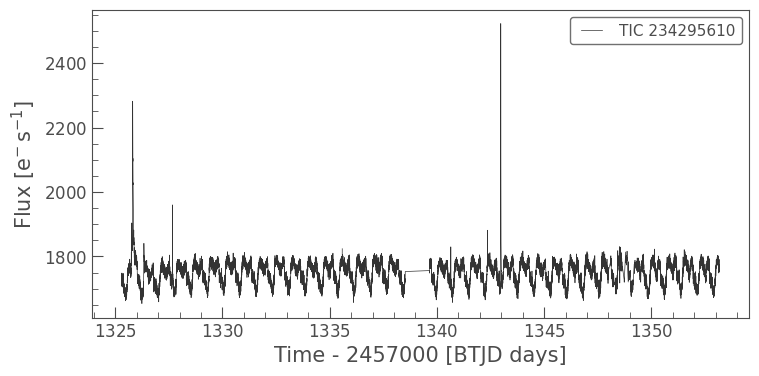

In [7]:
# ticids = ['278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
ticids = ['234295610']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
lc.plot()

In [5]:
rot_rates_constrained = np.loadtxt('rot_rates_constrained.txt')
flare_rates_durations = np.loadtxt('flare_rates_durations.txt')

In [8]:
lc2 = lc.remove_nans().remove_outliers()
lc2 = lc2[:5000]
_, mask = lc2.flatten().remove_outliers(sigma=3.0, return_mask=True)
lc2 = lc2[~mask]

x = np.ascontiguousarray(lc2.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc2.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc2.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

In [9]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

with pm.Model() as model:
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(0.76), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize(progress=True)

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17797.54833147572 -> -15571.358082651843


INTRODUCE ABOVE: what is likelihood. what is "fitting a model to data".

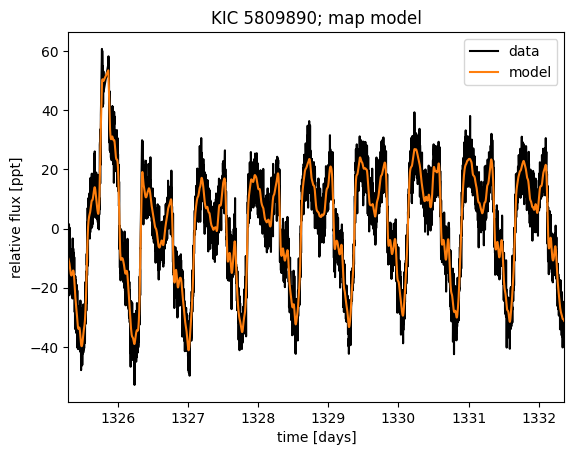

In [10]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

In [11]:
with model:
    trace = pmx.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        cores=4,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=[10863087, 10863088],
        progressbar=True
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 827 seconds.
/opt/conda/envs/tess/lib/python3.8/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


INTRODUCE ABOVE: what is sampling? why do we do it?

In [ ]:
# todo: why is there a pretty big difference between runs?

In [16]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "f",
        "log_dQ",
        "log_Q0",
        "log_period",
        "sigma_rot",
        "rho",
        "sigma",
        "log_jitter",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f,0.567,0.231,0.215,0.999,0.008,0.006,643.0,719.0,1.02
log_dQ,-1.166,2.067,-4.495,3.102,0.882,0.660,6.0,138.0,1.27
log_Q0,2.672,2.711,0.000,6.427,1.867,1.563,3.0,61.0,1.83
log_period,-0.919,0.072,-0.994,-0.758,0.035,0.026,6.0,87.0,1.69
sigma_rot,13.069,8.381,3.056,23.626,5.832,4.907,3.0,114.0,1.83
rho,0.630,0.396,0.239,1.305,0.240,0.192,3.0,89.0,1.83
sigma,9.597,7.528,1.003,18.916,5.240,4.410,3.0,55.0,1.83
log_jitter,-1.319,0.954,-3.181,0.056,0.034,0.025,1009.0,802.0,1.00
mean,0.154,2.662,-4.754,5.176,0.125,0.089,514.0,576.0,1.02


Describe: what are the numbers above?

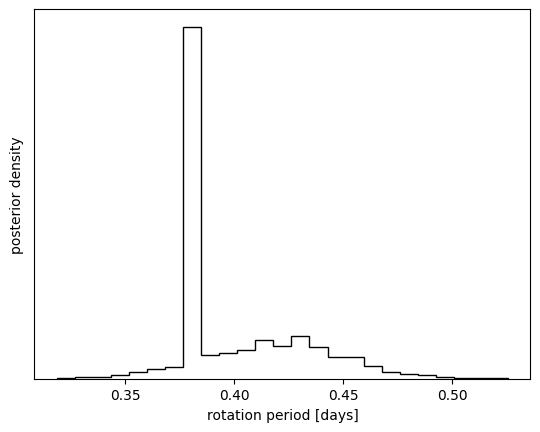

In [17]:
period_samples = np.asarray(trace.posterior["period"]).flatten()
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")

In [18]:
def fit_rotation_gp(name, period_init):
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    lc2 = lc.remove_nans().remove_outliers()
    lc2 = lc2[:5000]
    _, mask = lc2.flatten().remove_outliers(sigma=3.0, return_mask=True)
    lc2 = lc2[~mask]

    x = np.ascontiguousarray(lc2.time.value, dtype=np.float64)
    y = np.ascontiguousarray(lc2.flux, dtype=np.float64)
    yerr = np.ascontiguousarray(lc2.flux_err, dtype=np.float64)
    mu = np.mean(y)
    y = (y / mu - 1) * 1e3
    yerr = yerr * 1e3 / mu
    
    with pm.Model() as model:
        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sigma=10.0)

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

        # A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period = pm.Normal("log_period", mu=np.log(period_init), sigma=2.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.1, upper=1.0)

        # Set up the Gaussian Process model
        kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
        kernel += terms.RotationTerm(
            sigma=sigma_rot,
            period=period,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=x,
            diag=yerr**2 + tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=y)

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(y))

        # Optimize to find the maximum a posteriori parameters
        map_soln = pmx.optimize(progress=False)
        
    with model:
        trace = pmx.sample(
            tune=1000,
            draws=1000,
            start=map_soln,
            cores=4,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True,
            random_seed=[10863087, 10863088],
            progressbar=False
        )
        
    period_samples = np.asarray(trace.posterior["period"]).flatten()
    np.save(f'period_samples{name}.npy', period_samples)
    return period_samples


    

Mention: the above is just wrapping an earlier code block in a function.

Below: Say that this can take an hour or so to run. You can run the whole thing, or you can skip to loading in our answers. We promise that you'd arrive at the same answer :)

In [15]:
rot_rates_gp = []

# iterate though stars
for i, star in tqdm(enumerate(stars[::200]), total=len(stars[::200])):
    # if i <= 2: # already calculated
    #     continue
    star_name = str(star) # the rotation rate function takes strings
    period_guess = rot_rates_constrained[i]
    
    rot_rate_gp_samples = fit_rotation_gp(star_name, period_guess)
    
    # store result of rotation rate calculation
    rot_rates_gp += [rot_rate_gp_samples]

NameError: name 'stars' is not defined

We can plot a few of these distributions to get a sense of scale here.

In [ ]:
plt.hist(rot_rates_gp[0])
plt.hist(rot_rates_gp[1])
plt.hist(rot_rates_gp[-1])
plt.xlabel('Period (days)')
plt.ylabel('Count')

In [20]:
stars = np.loadtxt('stars.txt')

It looks like there's pretty significant spread in the distributions of periods and the associated scales.

In [24]:
# if loading back in after performing the computations
rot_rates_gp = []
# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    data = np.load(f'period_samples{int(eval(star_name))}.npy')
    rot_rates_gp += [data]

100%|██████████| 44/44 [00:00<00:00, 378.09it/s]


to-do: describe hierarchical bayesian modeling. and walk through the Lustig-Yaeger equations a bit.

Now it's time to perform our hierarchical Bayesian sampling, following the prescription of [Lustig-Yaeger et al. 2022](https://iopscience.iop.org/article/10.3847/1538-3881/ac5034/meta). Note that because the likelihood function contains a nested loop, we get a few orders of magnitude speed-up by using the Numba package.

todo: have them run the below functions with and without numba, so that they can see that they *need* it?

In [25]:
@njit
def hyperprior(hypertheta):
    """
    Prior for the population-level trend describing the relationship between (log) flare rate and (log) rotation rate.
    
    Inputs
    ------
        :hypertheta: (array) parameters for the population-level trend.
        
    Output
    ------
        :hyperprior_val: (float) value of the prior.
    """
    
    # todo: describe the top hat function
    m, b, sigma_2 = hypertheta
    if not (-7 < m < 7 and -10 < b < 10 and sigma_2 > 0.2):
        return -np.inf

    
    # gaussian prior on sigma_2. todo: describe.
    mu = 0
    sigma = 1
    return np.log(1.0 / (np.sqrt(2 * np.pi) * sigma)) - 0.5 * (sigma_2 - mu)**2 / sigma**2

In [49]:
@njit
def f_rotation(m, b, flare): # just a log-linear functional form
    """
    this is the function that returns the LOG rotation rate. it encodes the population trend.
    
    Inputs
    ------
        :m: (float) slope of trend.
        :b: (float) intercept of trend.
        :flare: (float) flare rate.
    """
    return m * np.log10(flare) + b

In [27]:
@njit
def posterior_hierarchical(hypertheta, samples, flare_rates_durations_cleaned, rot_rates_constrained):
    """
    The posterior distribution of the population-level trend.
    
    Technically this is the probability function...change!
    """
    m, b, sigma_2 = hypertheta
    # likelihood * P_a
    
    hyperprior_val = hyperprior(hypertheta)
    
    if not np.isfinite(hyperprior_val):
        return -np.inf
    
    # error maybe in likelihood func
    likelihood_val = likelihood_hierarchical(samples, m, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained)
    
    return likelihood_val + hyperprior_val

In [28]:
@njit
def updated_prior(rotation_inferred, m, b, flare_rate, sigma_2):
    """
    The prior of a given star's rotation rate, updated to reflect the contribution from the population-level trend.
    """
    # this is P_alpha
    sigma = sigma_2


    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-f_rotation(m, b, flare_rate))**2/sigma**2 

In [29]:
@njit
def previous_prior(rotation_inferred, period_guess):
    """
    The prior of a given star's rotation rate.
    the pymc3 prior is normal in log sigma. oh, this is prior, not log prior!
    """
    sigma = 2 # from rotation rate prior.
    rotation_inferred_log = np.log10(rotation_inferred)
    mu = np.log10(period_guess)
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(rotation_inferred_log-mu)**2/sigma**2 

In [30]:
@njit
def likelihood_hierarchical(samples, m, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained):
    """
    The likelihood function of the population-level trend.
    
    the regular prior was normal in log period
    """
    
    # todo: walk through the summing below
    total_likelihood = 1.
    # looping over whole populatio
    for i, rotations_inferred in enumerate(samples):
        
        # right now looping over a single planet's retrieved rotation rate
        likelihood = 0.
        flare_rate = flare_rates_durations_cleaned[i]
        period_guess = rot_rates_constrained[i]
        for rotation_inferred in rotations_inferred:
            updated_prior_val = np.exp(updated_prior(rotation_inferred, m, b, flare_rate, sigma_2))
            previous_prior_val = np.exp(previous_prior(rotation_inferred, period_guess))
            prior_update = updated_prior_val / previous_prior_val
            likelihood += prior_update

        total_likelihood *= likelihood / len(rotations_inferred)
    
    return np.log(total_likelihood)

We're now all set up for our MCMC sampling. But where do we start the walkers? Let's instantiate them with a simple regression result.

todo: fix the below.

In [31]:
# perform regression on the log values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_durations_sorted),
                                                                     np.log10(np.mean(rot_rates_gp_sorted, axis=1)))

print(slope, intercept)

NameError: name 'flare_rates_durations_sorted' is not defined

In [32]:
rot_rates_gp = np.array(rot_rates_gp)
rot_rates_constrained = np.array(rot_rates_constrained)

In [33]:
# todo: reset x and y and yerr

n_dim = 3
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?

# period_guess = 0.76

rot_rates_constrained_cleaned = rot_rates_constrained[flare_rates_durations>0.0]
rot_rates_gp_cleaned = rot_rates_gp[flare_rates_durations>0.0]
flare_rates_durations_cleaned = flare_rates_durations[flare_rates_durations>0.0]

flare_rates_durations_sorted = np.sort(np.log10(flare_rates_durations_cleaned))

rot_rates_constrained_sorted = rot_rates_constrained_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]

rot_rates_gp_sorted = rot_rates_gp_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]


initial_point = np.array([-3.5, 2.7, .5]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-3 # want the walkers to each start at a slightly different location.

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, n_dim)



sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, posterior_hierarchical, args=(rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)
)
sampler.run_mcmc(pos, n_steps, progress=True);



100%|██████████| 5000/5000 [04:36<00:00, 18.09it/s]


In [ ]:
# todo: explain the MCMC sampling above. and the trace plots below.

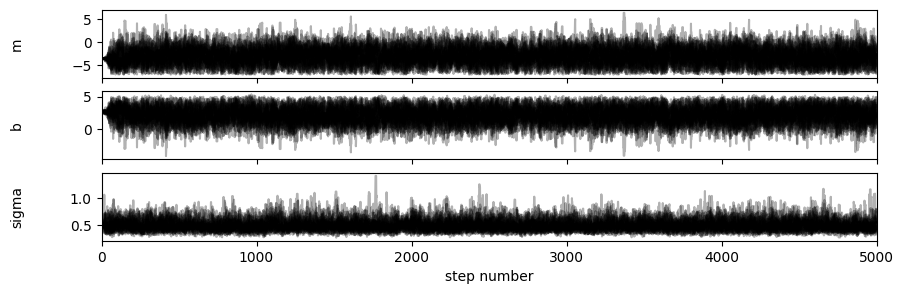

In [34]:
fig, axes = plt.subplots(n_dim, figsize=(10, 3), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'b', 'sigma']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
# todo: what's the autocorrelation?

In [35]:
tau = sampler.get_autocorr_time()
print(tau)

[41.92142065 41.6395838  42.31992597]


We can discard a few multiples of the autocorrelation time.

In [36]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


In [ ]:
# todo: what are these samples?

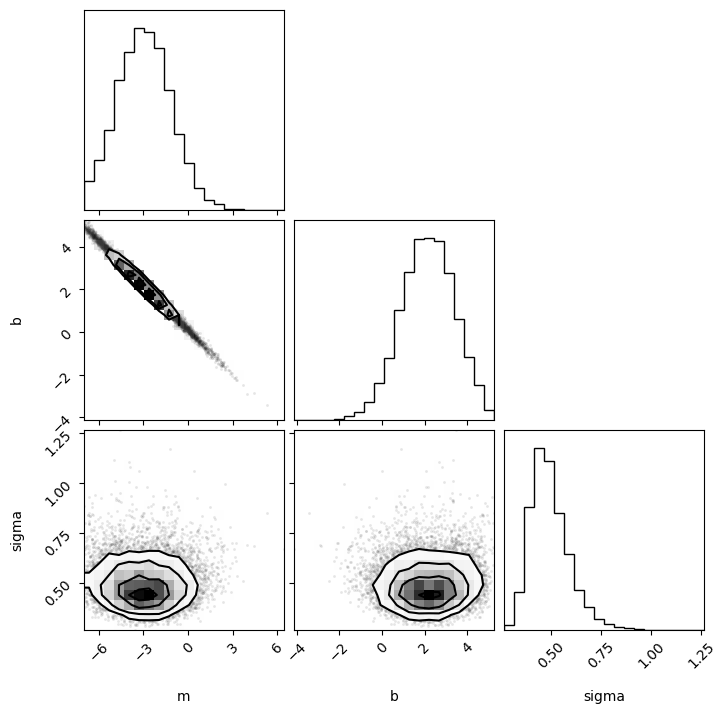

In [37]:
import corner
fig = corner.corner(
    flat_samples, labels=labels
);

Loosely, we can plot the error on a single rotation period as the standard deviation of its posterior distribution.

In [38]:
yerr = np.std(rot_rates_gp_sorted, axis=1)

In [ ]:
# todo: explain the draws below.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


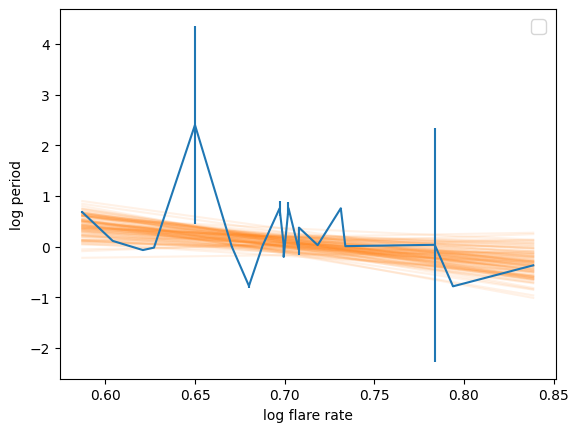

In [39]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(np.log10(flare_rates_durations_sorted), (np.dot(np.vander(np.log10(flare_rates_durations_sorted), 2), sample[:2])), "C1", alpha=0.1)
plt.errorbar(np.log10(flare_rates_durations_sorted),np.log10(np.mean(rot_rates_gp_sorted, axis=1)),
            yerr=yerr/np.mean(rot_rates_gp_sorted, axis=1) / np.log(10),)
# plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
# plt.
plt.legend(fontsize=14)
# plt.xlim(0, 10)
plt.xlabel("log flare rate")
plt.ylabel("log period");

Looks like we can decently fit a trend line to these rotation rates. How would a flat line perform?

In [50]:
# todo: make them implement f_rotation_flat as an in-notebook exercise.

In [40]:
# now need likelihood
@njit
def updated_prior_flat(rotation_inferred, b, flare_rate, sigma_2):
    # this is P_alpha
    # this should probably be log difference, right
    # mu = np.log10(rotation_inferred) - f_rotation(m, b, flare_rate) # the sample - the calculated trend. 
    sigma = sigma_2
    # pdb.set_trace()
    # return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-mu)**2/sigma**2 
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-f_rotation_flat(b, flare_rate))**2/sigma**2 

@njit
def likelihood_hierarchical_flat(samples, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained):
    """
    the regular prior was normal in log period
    """
    total_likelihood = 1.
    # looping over whole populatio
    for i, rotations_inferred in enumerate(samples):
        # right now looping over a single planet's retrieved rotation rate
        likelihood = 0.
        flare_rate = flare_rates_durations_cleaned[i]
        period_guess = rot_rates_constrained[i]
        for rotation_inferred in rotations_inferred:
            updated_prior_val = np.exp(updated_prior_flat(rotation_inferred, b, flare_rate, sigma_2))
            previous_prior_val = np.exp(previous_prior(rotation_inferred, period_guess))
            prior_update = updated_prior_val / previous_prior_val
            likelihood += prior_update
            # if np.isnan(likelihood):
            #     pdb.set_trace()
            # if likelihood < 0:
            #     pdb.set_trace()
        total_likelihood *= likelihood / len(rotations_inferred)
    
    return np.log(total_likelihood)

@njit
def posterior_hierarchical_flat(hypertheta, samples, flare_rates_durations_cleaned, rot_rates_constrained):
    b, sigma_2 = hypertheta
    # likelihood * P_a
    
    hyperprior_val = hyperprior_flat(hypertheta)
    
    if not np.isfinite(hyperprior_val):
        return -np.inf
    
    # error maybe in likelihood func
    likelihood_val = likelihood_hierarchical_flat(samples, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained)
    
    # if np.isnan(likelihood_val):
    #     pdb.set_trace()
    return likelihood_val + hyperprior_val

@njit
def f_rotation_flat(b, flare): # just a log-linear functional form
    """
    this is the function that returns the LOG rotation rate.
    """
    return b

# we have all of these. now do a hyperprior.
@njit
def hyperprior_flat(hypertheta):
    b, sigma_2 = hypertheta
    if not (-10 < b < 10 and sigma_2 > 0.2):
        return -np.inf

    
    #gaussian prior on sigma_2
    mu = 0
    sigma = 1
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(sigma_2-mu)**2/sigma**2

In [41]:

n_dim = 2
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?

# period_guess = 0.76

rot_rates_constrained_cleaned = rot_rates_constrained[flare_rates_durations>0.0]
rot_rates_gp_cleaned = rot_rates_gp[flare_rates_durations>0.0]
flare_rates_durations_cleaned = flare_rates_durations[flare_rates_durations>0.0]

flare_rates_durations_sorted = np.sort(np.log10(flare_rates_durations_cleaned))

rot_rates_constrained_sorted = rot_rates_constrained_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]

rot_rates_gp_sorted = rot_rates_gp_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]


initial_point = np.array([2.7, .5]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-3 # seems fine. justify?

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, n_dim)



sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, posterior_hierarchical_flat, args=(rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)
)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|██████████| 5000/5000 [04:47<00:00, 17.38it/s]


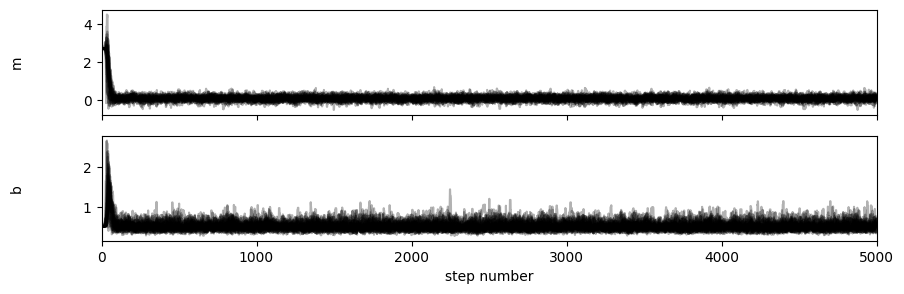

In [42]:
fig, axes = plt.subplots(n_dim, figsize=(10, 3), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'b', 'sigma']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [43]:
tau = sampler.get_autocorr_time()
print(tau)

[48.61628267 36.92136175]


In [44]:
flat_samples_flat = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


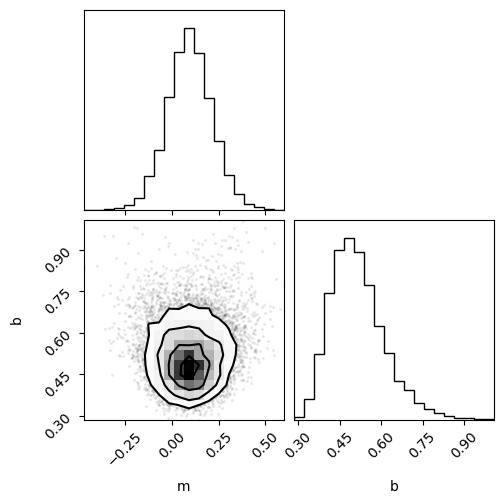

In [45]:
import corner
fig = corner.corner(
    flat_samples_flat, labels=labels
);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


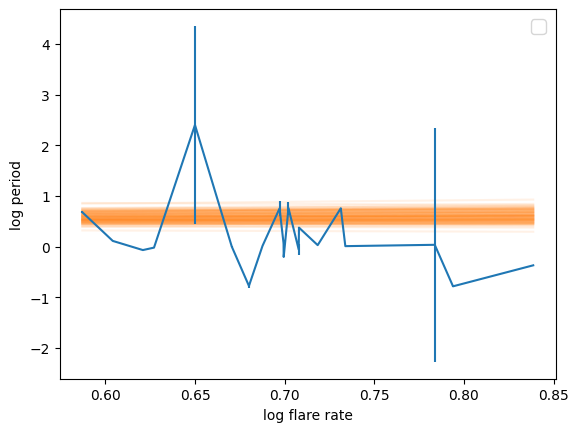

In [46]:
inds = np.random.randint(len(flat_samples_flat), size=100)
for ind in inds:
    sample = flat_samples_flat[ind]
    plt.plot(np.log10(flare_rates_durations_sorted), (np.dot(np.vander(np.log10(flare_rates_durations_sorted), 2), sample[:2])), "C1", alpha=0.1)
plt.errorbar(np.log10(flare_rates_durations_sorted),np.log10(np.mean(rot_rates_gp_sorted, axis=1)),
            yerr=yerr/np.mean(rot_rates_gp_sorted, axis=1) / np.log(10),)
# plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
# plt.
plt.legend(fontsize=14)
# plt.xlim(0, 10)
plt.xlabel("log flare rate")
plt.ylabel("log period");

Todo: explain why the half-violin plot below is better.

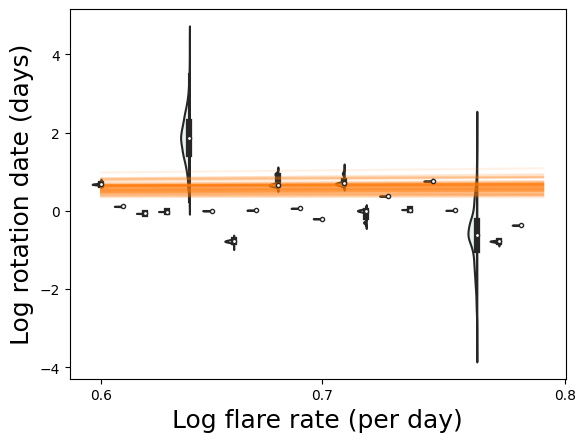

In [47]:
dat = pd.DataFrame({'flare':np.repeat(np.log10(flare_rates_durations_sorted),2000),
              'rot':np.log10(rot_rates_gp_sorted.flatten())})
fig, ax = plt.subplots()
sns.violinplot(
    data=dat,
    x="flare", y="rot", hue=True,
    hue_order=[True, False], split=True, scale_hue=12,color='teal',ax=ax
)
ax.legend_ = None
ax.set_xticks([0.,10, 21], [0.6, 0.7, 0.8])
# ax.set_yscale('log')
ax.set_xlabel('Log flare rate (per day)', fontsize=18)
ax.set_ylabel('Log rotation date (days)', fontsize=18)

inds = np.random.randint(len(flat_samples_flat), size=100)
for ind in inds:
    sample = flat_samples_flat[ind]
    ax.plot(20 * (np.log10(flare_rates_durations_sorted) -0.58708446)/ (0.83866827 - 0.58708446), (np.dot(np.vander(np.log10(flare_rates_durations_sorted), 2), sample[:2])), "C1", alpha=0.1)
# ax.errorbar(np.log10(flare_rates_durations_sorted)* 21/0.8,np.log10(np.mean(rot_rates_gp_sorted, axis=1)),
#             yerr=yerr/np.mean(rot_rates_gp_sorted, axis=1) / np.log(10),)




In [48]:
#need to take the median sample and do BIC

def calc_bic(log_likelihood, n_points, n_params):
    """
    calculates the Bayesian Information Criterion.
    """
    bic = -2 * log_likelihood + np.log(n_points) * n_params
    return bic
n_points = 20
# do BIC.
flat_chain_mean = np.mean(flat_samples, axis=0)
log_likelihood_trend = posterior_hierarchical(flat_chain_mean, rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)

flat_chain_flat_mean = np.mean(flat_samples_flat, axis=0)
log_likelihood_flat = posterior_hierarchical_flat(flat_chain_flat_mean, rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)


bic_trend = calc_bic(log_likelihood_trend, n_points, 3)
bic_flat = calc_bic(log_likelihood_flat, n_points, 2)

delta_bic = bic_trend - bic_flat
delta_bic

0.08066879651158487

We've calcualted a $\Delta$BIC of 0.1. In general, we look for a $\Delta$BIC greater than 2 before we consider the data to prefer one model over the other (cite?).

That's a long way of saying that the trend we found was not statistically significant — even though it aligned with our predictions!

That's not to say that our approach is flawed. It may be that further observations could help us differentiate between a trend and a flat line.

Todo: explain the BIC more.

# Additional exercises<a name="more_exercises"></a>
1. Perform the above but for a half-tailed Gaussian distribution. Is a flat line still a better fit?
2